<a href="https://colab.research.google.com/github/MaslovAleksey/Gradient-descent-optimization/blob/main/Gradient_descent_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Оптимизация градиентного спуска**

## **1.) Техническое описание**

* ### **Постановка задачи:**
> #### Реализовать классификцию датасета *IRIS*, используя библиотеку *tensorflow*. Внедрить в алгоритм собственную реализацию механизма оптимизации градиентного спуска *Adam*.

---

* ### **Используемые библиотеки и модули:**
> ####    numpy, math, os, colab, shutil, tensorflow, keras, matplotlib, tqdm, sklearn, PIL, datetime.

---

* ### **Данные для обучения:**
> #### 1.   В качестве данных для обучения используется датасет *IRIS*;
> #### 2.   Набор содержит всего 150 записей, что весьма немного.
> #### 3.   Разделение на тренировочную и тестовую выборки производим в соотношении 75/25;
> #### 4.   Объекты из набора данных имеют 4 признака: *sepal length*, *sepal width*, *petal length*, *petal width*;
> #### 5.   Данные проходят *MinMax* нормализацию;   

---

* ### **Особенности реализации алгоритма:**
> #### 1.   В качестве нейронной сети используется простая полносвязная модель.
> #### 2.   Нецелесообразно выделять отдельно проверочную выборку вследствие малого объёма данных.
> #### 3.   В качестве оптимизатора может выступать *Adagrad* или *Adam*.
> #### 4.   В роли ошибки выступает *tf.losses.categorical_crossentropy().*

## **2.) Подготовка данных**

### **Подключение необходимых библиотек**

In [ ]:
import numpy as np
from google.colab import drive
import math
import tensorflow as tf
import matplotlib.pyplot as plt
# import random
import datetime
from tqdm.auto import tqdm # прогресс бар
import os
import shutil
# Отрисовка в ноутбуке
%matplotlib inline 

from sklearn.datasets import load_iris 
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils # Инструменты, содержащие to_categorical
from tensorflow.keras.preprocessing import image # Инструменты для отрисовки изображений
from PIL import Image

### **Загрузка данных для обучения из набора IRIS**

In [ ]:
dataset = load_iris()

In [ ]:
print("\033[1mОписание датасета:\033[0m")
print(dataset.DESCR)

Описание датасета:
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======

In [ ]:
x_data = dataset.data
y_data = dataset.target

In [ ]:
print(f"\033[1mРазмерность x_data\033[0m - {x_data.shape}")
print(f"\033[1mРазмерность y_data\033[0m - {y_data.shape}")

Размерность x_data - (150, 4)
Размерность y_data - (150,)


### **Глобальные переменные**

In [ ]:
names_cls = dataset.target_names
names_features = dataset.feature_names
num_cls = len(names_cls)
num_features = len(names_features)

In [ ]:
print(f"\033[1mНаименования классов\033[0m - {names_cls}")
print(f"\033[1mНаименования признаков объектов\033[0m - {names_features}")
print(f"\033[1mКоличество признаков объекта\033[0m - {num_features}")

Наименования классов - ['setosa' 'versicolor' 'virginica']
Наименования признаков объектов - ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Количество признаков объекта - 4


## **3.) Необходимые функции**

### **Формирование наборов данных**

In [ ]:
def get_datasets(x_data, y_data, test_per):
  test_per = test_per / 100

  # Нормализация данных
  x_data_max = np.max(x_data, axis=0) # максимальные значения признаков
  x_data_min = np.min(x_data, axis=0) # максимальные значения признаков
  x_data = (x_data - x_data_min) / (x_data_max - x_data_min)

  # Приведение к формату OHE
  y_data = utils.to_categorical(y_data, num_cls)

  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_per, shuffle=True)

  return x_train, y_train, x_test, y_test

### **Создание матрицы размерностей**

In [ ]:
def create_layers_data(num_layers):

  layers_data = [] # информация о слоях
  out_filters = num_features # количество входных фильтров

  print("\033[1mФормировние матрицы размерностей\033[0m")
  for i in range(num_layers):
    in_filters = out_filters
    layer_data = {}

    if (i == num_layers-1): # последний слой 
      print("\033[1m\nВыходной слой\033[0m")
      print(f"Число нейронов - {num_cls}")
      print("Функция активации - softmax")
      out_filters = num_cls
    else:
      print(f"\033[1m\nСлой №{i+1}\033[0m")
      out_filters = int(input("Число нейронов - "))
      layer_data["relu"] = input("Использование Relu активации (yes/no) - ")
      layer_data["dropout"] = input("Использование слоя Dropout (yes/no) - ")

    shape = [in_filters, out_filters]
    layer_data["shape"] = shape

    layers_data.append(layer_data)

  return layers_data

### **Полносвязный слой**

In [ ]:
def dense(x, weights, layer_data, drop_rate, last_layer):
  x = x @ weights

  # Последний слой 
  if last_layer:
    x = tf.nn.softmax(x, axis = -1)
  else:
    if (layer_data["relu"] == "да"):
      x = tf.nn.relu(x)
    if (layer_data["dropout"] == "да"):
      x = tf.nn.dropout(x, rate=drop_rate)
  
  return x

### **Класс модели нейронной сети**

In [ ]:
'''

Класс нейронной сети, наследующий класс object.

1.) Объекты данного класса хранят в себе информацию о весах полносвязных слоёв. 
Сами слои при этом не сохраняются.

2.) Полносвязный слой реализован в виде функций, которые вызываются
из метода predict.

3.) Веса нейронной сети корректируются во время обучения. 

'''

class DenseModel(object):

  # 1.) Конструктор класса
  def __init__(self, layers_data, drop_rate, initializer):
    self.layers_data = layers_data
    self.num_layers = len(layers_data)
    self.drop_rate = drop_rate
    self.initializer = initializer

    # Инициализация весов
    self.weights_trainable = []
    for layer_data in layers_data:
      curr_weights = tf.Variable(initial_value=self.initializer(layer_data["shape"]), trainable=True, dtype=tf.float32)
      self.weights_trainable.append(curr_weights)

  
  # 2.) Выполнение предсказания
  def predict(self, x):
    x = tf.cast(x, dtype=tf.float32) # приведение -> tf.float32

    for i in range(self.num_layers):
      last = (i==self.num_layers-1) # флаг последнего слоя
      x = dense(x, self.weights_trainable[i], self.layers_data[i], self.drop_rate, last)
    
    return x

### **Класс оптимизатора**

In [ ]:
'''

Данный класс позволяет реализовать оптимизаторы двух видов:

1.) При параметре self.use_Adam = "no" получаем оптимизатор Adagrad
  new_w = old_w - dL_dw * adapt_lr
  adapt_lr = lr / (dL_dw**2 + eps)**0.5

2.) При параметре self.use_Adam = "yes" получаем оптимизатор Adam
  self.m = self.b1 * self.m + (1 - self.b1) * dL_dw
  self.v = self.b2 * self.v + (1 - self.b2) * (dL_dw)**2
  adapt_lr = self.lr / (self.v + self.eps)**0.5
  new_w = old_w - self.m * adapt_lr

'''

class My_Optimizer:
  # 1.) Конструктор класса
  def __init__(self, optimizer_params, num_layers, eps = 1e-6):
   self.lr = optimizer_params["learning_rate"]
   self.use_Adam = optimizer_params["use_Adam"]
   self.eps = eps
   self.m = [0 for _ in range(num_layers)] # momentum
   self.v = [0 for _ in range(num_layers)] # cache

   if (self.use_Adam == "yes"):
     self.b1 = optimizer_params["beta1"]
     self.b2 = optimizer_params["beta2"]
   else:
     self.b1 = 0
     self.b2 = 0

  # 2.) Метод обновления весов 
  def apply_gradients(self, data):
    grads = data[0]
    weights = data[1]
    num_layers = len(weights) # число слоёв

    for l in range(num_layers):
      dL_dw = grads[l] 
      old_w = weights[l]
      self.m[l] = self.b1 * self.m[l] + (1 - self.b1) * dL_dw
      self.v[l] = self.b2 * self.v[l] + (1 - self.b2) * (dL_dw)**2
      adapt_lr = self.lr / (self.v[l] + self.eps)**0.5

      new_w = old_w - self.m[l] * adapt_lr
      weights[l] = new_w

### **Вычисление точности**

In [ ]:
def precision_calculation(real_data, pred_data):
  pred_numbers = np.argmax(pred_data, axis=-1) # предсказание сети
  real_numbers = np.argmax(real_data, axis=-1) # истинные значения
  eqls_numb = np.sum(pred_numbers==real_numbers, axis=-1) # число верно распознанных классов
  all_numb = len(pred_numbers)

  prec = eqls_numb/all_numb

  return prec

### **Функция ошибки**

In [ ]:
def loss(real, pred):
  cross = tf.losses.categorical_crossentropy(real, pred)
  return cross

### **Тренировка сети на батче данных**

In [ ]:
def train_on_batch(model, batch_x_train, batch_y_train, optimizer):
  # Отслеживание значений ошибки
  with tf.GradientTape() as g:
    g.watch(model.weights_trainable)
    batch_pred = model.predict(batch_x_train)
    batch_losses = loss(batch_y_train, batch_pred)

  # Вычисление частных производных
  grads = g.gradient(batch_losses, model.weights_trainable) # d_Loss/d_Weights

  # Обновление весов
  optimizer.apply_gradients([grads, model.weights_trainable])

  # Средняя ошибка и точность на батче
  batch_loss = tf.reduce_mean(batch_losses, axis=-1)
  batch_acc = precision_calculation(batch_y_train, batch_pred)

  return batch_loss, batch_acc

### **Визуализация процесса обучения**

In [ ]:
def plot_parameters(train_loss, train_acc):
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Ошибка в процессе обучения", size=16, pad=20)
  ax.plot(train_loss, label="тренировочные данные")
  # ax.plot(val_loss, label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Ошибка обучения", size=12)
  ax.legend(prop={"size":12})
  plt.show()
  
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Изменение точности предсказания", size=16, pad=20)
  ax.plot(train_acc, label="тренировочные данные")
  # ax.plot(val_acc, label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Точность", size=12)
  ax.legend(prop={"size":12})
  plt.show()

### **Обучение нейронной сети**

In [ ]:
def model_training(model, x_train, y_train, epochs, batch_size, optimizer_params, path_data, num_layers):
  # Подготовка к записи данных в файл
  # if (os.path.exists(path_data)): # проверка на наличие данных по указанному пути и удаление их
  #   shutil.rmtree(path_data)
  # os.mkdir(path_data)
  # current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  # loss_log_dir = path_data + "/" + current_time + "/data"
  # loss_summary_writer = tf.summary.create_file_writer(loss_log_dir)

  # Процесс обучения
  # with loss_summary_writer.as_default():
  train_loss = []
  train_acc = []
  # val_loss = []
  # val_acc = []

  n_train = x_train.shape[0]
  optimizer = My_Optimizer(optimizer_params, num_layers) # оптимайзер
  num_batches = math.ceil(n_train / batch_size) # число батчей
  
  for epoch in range(epochs):
    print(f"\033[1mЭпоха №{epoch+1}/{epochs}\033[0m")
    curr_ind = 0 # текущее положение индекса
    epoch_train_loss = [] # ошибка на данной эпохе
    epoch_train_acc = [] # точность на данной эпохе

    for j in tqdm(range(num_batches), bar_format='{l_bar}{bar}{remaining} c ', colour='cyan'):
      if curr_ind + batch_size <= n_train:
        need_inds = list(range(curr_ind, curr_ind+batch_size))
      else: 
        need_inds = list(range(curr_ind, n_train))

      batch_x_train = x_train[need_inds]
      batch_y_train = y_train[need_inds]

      batch_train_loss, batch_train_acc = train_on_batch(model, batch_x_train, batch_y_train, optimizer)

      epoch_train_loss.append(batch_train_loss)
      epoch_train_acc.append(batch_train_acc)
      curr_ind += batch_size
    
    # Вычисление параметров обучения 

    # 1.) Тренировочные данные
    epoch_train_loss = tf.reduce_mean(epoch_train_loss, axis=-1) # вычисление средней ошибки на эпохе
    epoch_train_acc = tf.reduce_mean(epoch_train_acc, axis=-1) # вычисление средней точности на эпохе

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # 2.) Проверочные данные
    # epoch_val_pred = model.predict(x_val)
    # epoch_val_loss = tf.reduce_mean(loss(y_val, epoch_val_pred), axis=-1)
    # epoch_val_acc = precision_calculation(y_val, epoch_val_pred)

    # val_loss.append(epoch_val_loss)
    # val_acc.append(epoch_val_acc)

    # print("\033[1mtrain_loss = %.4f, train_acc = %.4f, val_loss = %.4f, val_acc = %.4f\033[0m"  % (epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc))
    print("\033[1mtrain_loss = %.4f, train_acc = %.4f"  % (epoch_train_loss, epoch_train_acc))

    # Запись данных в файл
    # tf.summary.scalar("epoch_train_loss", epoch_train_loss, step=epoch)
    # tf.summary.scalar("epoch_val_loss", epoch_val_loss, step=epoch)


    # loss_summary_writer.flush()

  plot_parameters(train_loss, train_acc)

### **Классификация тестовой выборки**

In [ ]:
def test_recognition(model, x_test, y_test):
  y_pred = model.predict(x_test)
  
  test_acc = precision_calculation(y_test, y_pred)
  test_acc = round(test_acc, ndigits=4) * 100

  print(f"\033[1mТочность работы алгоритма на тестовой выборке - {test_acc} %\033[0m")

## **4.) Процесс реализации алгоритма**

### **Разделение данных на выборки**

In [ ]:
test_per = int(input("Процент тестовой выборки - "))

Процент тестовой выборки - 25


In [ ]:
x_train, y_train, x_test, y_test = get_datasets(x_data, y_data, test_per)

In [ ]:
print(f"\033[1mРазмерность x_train\033[0m - {x_train.shape}")
print(f"\033[1mРазмерность y_train\033[0m - {y_train.shape}")
print(f"\033[1mРазмерность x_test\033[0m - {x_test.shape}")
print(f"\033[1mРазмерность y_test\033[0m - {y_test.shape}")

Размерность x_train - (112, 4)
Размерность y_train - (112, 3)
Размерность x_test - (38, 4)
Размерность y_test - (38, 3)


### **Матрица размерностей**

In [ ]:
num_layers = int(input("Число полносвязных слоёв - "))

Число полносвязных слоёв - 4


In [ ]:
layers_data = create_layers_data(num_layers)

Формировние матрицы размерностей

Слой №1
Число нейронов - 256
Использование Relu активации (yes/no) - no
Использование слоя Dropout (yes/no) - np

Слой №2
Число нейронов - 512
Использование Relu активации (yes/no) - np
Использование слоя Dropout (yes/no) - no

Слой №3
Число нейронов - 128
Использование Relu активации (yes/no) - no
Использование слоя Dropout (yes/no) - no

Выходной слой
Число нейронов - 3
Функция активации - softmax


In [ ]:
print(f"\033[1mМатрица размерностей:\033[0m\n{layers_data}")

Матрица размерностей:
[{'relu': 'no', 'dropout': 'np', 'shape': [4, 256]}, {'relu': 'np', 'dropout': 'no', 'shape': [256, 512]}, {'relu': 'no', 'dropout': 'no', 'shape': [512, 128]}, {'shape': [128, 3]}]


### **Формирование архитектуры нейронной сети**

In [ ]:
drop_rate = float(input("Коэффициент слоя Dropout - "))
initializer = tf.initializers.glorot_uniform() # инициализатор переменных по форме на основе равномерного распределения

Коэффициент слоя Dropout - 0.3


In [ ]:
dense_model = DenseModel(layers_data, drop_rate, initializer)

### **Процесс обучения нейронной сети (без использования оптимизатора Adam)**

In [ ]:
epochs = int(input("Число эпох обучения - "))
batch_size = int(input("Размер батча - "))
# path_data = "/content/my_logs" # путь к файлу, сохраняющему данные для TensorBoard

Число эпох обучения - 200
Размер батча - 4


In [ ]:
# Параметры оптимизатора
optimizer_params = {}
optimizer_params["learning_rate"] = float(input("Шаг обучения - "))
optimizer_params["use_Adam"] = input("Использование оптимизатора Adam (yes/no) - ")
if (optimizer_params["use_Adam"] == "yes"):
  optimizer_params["beta1"] = input("Параметр beta1 - ") # beta1 = 0.9
  optimizer_params["beta2"] = input("Параметр beta2 - ") # beta1 = 0.999

Шаг обучения - 1e-5
Использование оптимизатора Adam (yes/no) - no


Эпоха №1/200


  0%|          ? c 

train_loss = 1.1985, train_acc = 0.3214
Эпоха №2/200


  0%|          ? c 

train_loss = 1.1362, train_acc = 0.3304
Эпоха №3/200


  0%|          ? c 

train_loss = 1.0841, train_acc = 0.5089
Эпоха №4/200


  0%|          ? c 

train_loss = 1.0402, train_acc = 0.6429
Эпоха №5/200


  0%|          ? c 

train_loss = 1.0022, train_acc = 0.6339
Эпоха №6/200


  0%|          ? c 

train_loss = 0.9688, train_acc = 0.6339
Эпоха №7/200


  0%|          ? c 

train_loss = 0.9387, train_acc = 0.6339
Эпоха №8/200


  0%|          ? c 

train_loss = 0.9111, train_acc = 0.6339
Эпоха №9/200


  0%|          ? c 

train_loss = 0.8854, train_acc = 0.6339
Эпоха №10/200


  0%|          ? c 

train_loss = 0.8614, train_acc = 0.6339
Эпоха №11/200


  0%|          ? c 

train_loss = 0.8385, train_acc = 0.6339
Эпоха №12/200


  0%|          ? c 

train_loss = 0.8168, train_acc = 0.6429
Эпоха №13/200


  0%|          ? c 

train_loss = 0.7961, train_acc = 0.6429
Эпоха №14/200


  0%|          ? c 

train_loss = 0.7763, train_acc = 0.6429
Эпоха №15/200


  0%|          ? c 

train_loss = 0.7573, train_acc = 0.6429
Эпоха №16/200


  0%|          ? c 

train_loss = 0.7392, train_acc = 0.6429
Эпоха №17/200


  0%|          ? c 

train_loss = 0.7219, train_acc = 0.6429
Эпоха №18/200


  0%|          ? c 

train_loss = 0.7054, train_acc = 0.6429
Эпоха №19/200


  0%|          ? c 

train_loss = 0.6897, train_acc = 0.6429
Эпоха №20/200


  0%|          ? c 

train_loss = 0.6747, train_acc = 0.6429
Эпоха №21/200


  0%|          ? c 

train_loss = 0.6606, train_acc = 0.6429
Эпоха №22/200


  0%|          ? c 

train_loss = 0.6472, train_acc = 0.6429
Эпоха №23/200


  0%|          ? c 

train_loss = 0.6346, train_acc = 0.6429
Эпоха №24/200


  0%|          ? c 

train_loss = 0.6227, train_acc = 0.6429
Эпоха №25/200


  0%|          ? c 

train_loss = 0.6115, train_acc = 0.6429
Эпоха №26/200


  0%|          ? c 

train_loss = 0.6010, train_acc = 0.6429
Эпоха №27/200


  0%|          ? c 

train_loss = 0.5912, train_acc = 0.6429
Эпоха №28/200


  0%|          ? c 

train_loss = 0.5820, train_acc = 0.6429
Эпоха №29/200


  0%|          ? c 

train_loss = 0.5735, train_acc = 0.6429
Эпоха №30/200


  0%|          ? c 

train_loss = 0.5655, train_acc = 0.6429
Эпоха №31/200


  0%|          ? c 

train_loss = 0.5580, train_acc = 0.6429
Эпоха №32/200


  0%|          ? c 

train_loss = 0.5511, train_acc = 0.6339
Эпоха №33/200


  0%|          ? c 

train_loss = 0.5446, train_acc = 0.6339
Эпоха №34/200


  0%|          ? c 

train_loss = 0.5386, train_acc = 0.6339
Эпоха №35/200


  0%|          ? c 

train_loss = 0.5330, train_acc = 0.6339
Эпоха №36/200


  0%|          ? c 

train_loss = 0.5278, train_acc = 0.6429
Эпоха №37/200


  0%|          ? c 

train_loss = 0.5229, train_acc = 0.6518
Эпоха №38/200


  0%|          ? c 

train_loss = 0.5184, train_acc = 0.6518
Эпоха №39/200


  0%|          ? c 

train_loss = 0.5142, train_acc = 0.6607
Эпоха №40/200


  0%|          ? c 

train_loss = 0.5103, train_acc = 0.6786
Эпоха №41/200


  0%|          ? c 

train_loss = 0.5066, train_acc = 0.6786
Эпоха №42/200


  0%|          ? c 

train_loss = 0.5032, train_acc = 0.6964
Эпоха №43/200


  0%|          ? c 

train_loss = 0.5000, train_acc = 0.6964
Эпоха №44/200


  0%|          ? c 

train_loss = 0.4970, train_acc = 0.6964
Эпоха №45/200


  0%|          ? c 

train_loss = 0.4941, train_acc = 0.6964
Эпоха №46/200


  0%|          ? c 

train_loss = 0.4915, train_acc = 0.6964
Эпоха №47/200


  0%|          ? c 

train_loss = 0.4890, train_acc = 0.7143
Эпоха №48/200


  0%|          ? c 

train_loss = 0.4866, train_acc = 0.7143
Эпоха №49/200


  0%|          ? c 

train_loss = 0.4844, train_acc = 0.7143
Эпоха №50/200


  0%|          ? c 

train_loss = 0.4823, train_acc = 0.7143
Эпоха №51/200


  0%|          ? c 

train_loss = 0.4803, train_acc = 0.7143
Эпоха №52/200


  0%|          ? c 

train_loss = 0.4784, train_acc = 0.7143
Эпоха №53/200


  0%|          ? c 

train_loss = 0.4767, train_acc = 0.7143
Эпоха №54/200


  0%|          ? c 

train_loss = 0.4750, train_acc = 0.7143
Эпоха №55/200


  0%|          ? c 

train_loss = 0.4734, train_acc = 0.7232
Эпоха №56/200


  0%|          ? c 

train_loss = 0.4718, train_acc = 0.7232
Эпоха №57/200


  0%|          ? c 

train_loss = 0.4704, train_acc = 0.7232
Эпоха №58/200


  0%|          ? c 

train_loss = 0.4690, train_acc = 0.7321
Эпоха №59/200


  0%|          ? c 

train_loss = 0.4676, train_acc = 0.7321
Эпоха №60/200


  0%|          ? c 

train_loss = 0.4663, train_acc = 0.7411
Эпоха №61/200


  0%|          ? c 

train_loss = 0.4651, train_acc = 0.7411
Эпоха №62/200


  0%|          ? c 

train_loss = 0.4639, train_acc = 0.7411
Эпоха №63/200


  0%|          ? c 

train_loss = 0.4628, train_acc = 0.7321
Эпоха №64/200


  0%|          ? c 

train_loss = 0.4617, train_acc = 0.7321
Эпоха №65/200


  0%|          ? c 

train_loss = 0.4607, train_acc = 0.7321
Эпоха №66/200


  0%|          ? c 

train_loss = 0.4596, train_acc = 0.7321
Эпоха №67/200


  0%|          ? c 

train_loss = 0.4587, train_acc = 0.7321
Эпоха №68/200


  0%|          ? c 

train_loss = 0.4577, train_acc = 0.7321
Эпоха №69/200


  0%|          ? c 

train_loss = 0.4568, train_acc = 0.7321
Эпоха №70/200


  0%|          ? c 

train_loss = 0.4559, train_acc = 0.7411
Эпоха №71/200


  0%|          ? c 

train_loss = 0.4551, train_acc = 0.7411
Эпоха №72/200


  0%|          ? c 

train_loss = 0.4542, train_acc = 0.7411
Эпоха №73/200


  0%|          ? c 

train_loss = 0.4534, train_acc = 0.7411
Эпоха №74/200


  0%|          ? c 

train_loss = 0.4526, train_acc = 0.7411
Эпоха №75/200


  0%|          ? c 

train_loss = 0.4519, train_acc = 0.7411
Эпоха №76/200


  0%|          ? c 

train_loss = 0.4511, train_acc = 0.7411
Эпоха №77/200


  0%|          ? c 

train_loss = 0.4504, train_acc = 0.7411
Эпоха №78/200


  0%|          ? c 

train_loss = 0.4497, train_acc = 0.7411
Эпоха №79/200


  0%|          ? c 

train_loss = 0.4490, train_acc = 0.7411
Эпоха №80/200


  0%|          ? c 

train_loss = 0.4483, train_acc = 0.7411
Эпоха №81/200


  0%|          ? c 

train_loss = 0.4477, train_acc = 0.7411
Эпоха №82/200


  0%|          ? c 

train_loss = 0.4470, train_acc = 0.7411
Эпоха №83/200


  0%|          ? c 

train_loss = 0.4464, train_acc = 0.7411
Эпоха №84/200


  0%|          ? c 

train_loss = 0.4458, train_acc = 0.7411
Эпоха №85/200


  0%|          ? c 

train_loss = 0.4452, train_acc = 0.7411
Эпоха №86/200


  0%|          ? c 

train_loss = 0.4446, train_acc = 0.7411
Эпоха №87/200


  0%|          ? c 

train_loss = 0.4440, train_acc = 0.7411
Эпоха №88/200


  0%|          ? c 

train_loss = 0.4434, train_acc = 0.7411
Эпоха №89/200


  0%|          ? c 

train_loss = 0.4429, train_acc = 0.7411
Эпоха №90/200


  0%|          ? c 

train_loss = 0.4423, train_acc = 0.7411
Эпоха №91/200


  0%|          ? c 

train_loss = 0.4418, train_acc = 0.7411
Эпоха №92/200


  0%|          ? c 

train_loss = 0.4413, train_acc = 0.7411
Эпоха №93/200


  0%|          ? c 

train_loss = 0.4408, train_acc = 0.7411
Эпоха №94/200


  0%|          ? c 

train_loss = 0.4403, train_acc = 0.7411
Эпоха №95/200


  0%|          ? c 

train_loss = 0.4398, train_acc = 0.7411
Эпоха №96/200


  0%|          ? c 

train_loss = 0.4393, train_acc = 0.7411
Эпоха №97/200


  0%|          ? c 

train_loss = 0.4388, train_acc = 0.7411
Эпоха №98/200


  0%|          ? c 

train_loss = 0.4383, train_acc = 0.7411
Эпоха №99/200


  0%|          ? c 

train_loss = 0.4379, train_acc = 0.7500
Эпоха №100/200


  0%|          ? c 

train_loss = 0.4374, train_acc = 0.7500
Эпоха №101/200


  0%|          ? c 

train_loss = 0.4370, train_acc = 0.7500
Эпоха №102/200


  0%|          ? c 

train_loss = 0.4365, train_acc = 0.7500
Эпоха №103/200


  0%|          ? c 

train_loss = 0.4361, train_acc = 0.7500
Эпоха №104/200


  0%|          ? c 

train_loss = 0.4357, train_acc = 0.7500
Эпоха №105/200


  0%|          ? c 

train_loss = 0.4352, train_acc = 0.7500
Эпоха №106/200


  0%|          ? c 

train_loss = 0.4348, train_acc = 0.7500
Эпоха №107/200


  0%|          ? c 

train_loss = 0.4344, train_acc = 0.7500
Эпоха №108/200


  0%|          ? c 

train_loss = 0.4340, train_acc = 0.7500
Эпоха №109/200


  0%|          ? c 

train_loss = 0.4336, train_acc = 0.7500
Эпоха №110/200


  0%|          ? c 

train_loss = 0.4332, train_acc = 0.7500
Эпоха №111/200


  0%|          ? c 

train_loss = 0.4329, train_acc = 0.7500
Эпоха №112/200


  0%|          ? c 

train_loss = 0.4325, train_acc = 0.7500
Эпоха №113/200


  0%|          ? c 

train_loss = 0.4321, train_acc = 0.7500
Эпоха №114/200


  0%|          ? c 

train_loss = 0.4318, train_acc = 0.7500
Эпоха №115/200


  0%|          ? c 

train_loss = 0.4314, train_acc = 0.7500
Эпоха №116/200


  0%|          ? c 

train_loss = 0.4310, train_acc = 0.7500
Эпоха №117/200


  0%|          ? c 

train_loss = 0.4307, train_acc = 0.7500
Эпоха №118/200


  0%|          ? c 

train_loss = 0.4304, train_acc = 0.7500
Эпоха №119/200


  0%|          ? c 

train_loss = 0.4300, train_acc = 0.7500
Эпоха №120/200


  0%|          ? c 

train_loss = 0.4297, train_acc = 0.7500
Эпоха №121/200


  0%|          ? c 

train_loss = 0.4294, train_acc = 0.7500
Эпоха №122/200


  0%|          ? c 

train_loss = 0.4290, train_acc = 0.7500
Эпоха №123/200


  0%|          ? c 

train_loss = 0.4287, train_acc = 0.7500
Эпоха №124/200


  0%|          ? c 

train_loss = 0.4284, train_acc = 0.7500
Эпоха №125/200


  0%|          ? c 

train_loss = 0.4281, train_acc = 0.7500
Эпоха №126/200


  0%|          ? c 

train_loss = 0.4278, train_acc = 0.7500
Эпоха №127/200


  0%|          ? c 

train_loss = 0.4275, train_acc = 0.7500
Эпоха №128/200


  0%|          ? c 

train_loss = 0.4272, train_acc = 0.7500
Эпоха №129/200


  0%|          ? c 

train_loss = 0.4270, train_acc = 0.7500
Эпоха №130/200


  0%|          ? c 

train_loss = 0.4267, train_acc = 0.7589
Эпоха №131/200


  0%|          ? c 

train_loss = 0.4264, train_acc = 0.7589
Эпоха №132/200


  0%|          ? c 

train_loss = 0.4262, train_acc = 0.7589
Эпоха №133/200


  0%|          ? c 

train_loss = 0.4259, train_acc = 0.7589
Эпоха №134/200


  0%|          ? c 

train_loss = 0.4256, train_acc = 0.7589
Эпоха №135/200


  0%|          ? c 

train_loss = 0.4254, train_acc = 0.7589
Эпоха №136/200


  0%|          ? c 

train_loss = 0.4252, train_acc = 0.7679
Эпоха №137/200


  0%|          ? c 

train_loss = 0.4249, train_acc = 0.7679
Эпоха №138/200


  0%|          ? c 

train_loss = 0.4247, train_acc = 0.7768
Эпоха №139/200


  0%|          ? c 

train_loss = 0.4245, train_acc = 0.7768
Эпоха №140/200


  0%|          ? c 

train_loss = 0.4242, train_acc = 0.7768
Эпоха №141/200


  0%|          ? c 

train_loss = 0.4240, train_acc = 0.7768
Эпоха №142/200


  0%|          ? c 

train_loss = 0.4238, train_acc = 0.7768
Эпоха №143/200


  0%|          ? c 

train_loss = 0.4236, train_acc = 0.7768
Эпоха №144/200


  0%|          ? c 

train_loss = 0.4234, train_acc = 0.7768
Эпоха №145/200


  0%|          ? c 

train_loss = 0.4232, train_acc = 0.7857
Эпоха №146/200


  0%|          ? c 

train_loss = 0.4230, train_acc = 0.7857
Эпоха №147/200


  0%|          ? c 

train_loss = 0.4228, train_acc = 0.7857
Эпоха №148/200


  0%|          ? c 

train_loss = 0.4227, train_acc = 0.7946
Эпоха №149/200


  0%|          ? c 

train_loss = 0.4225, train_acc = 0.7946
Эпоха №150/200


  0%|          ? c 

train_loss = 0.4223, train_acc = 0.7946
Эпоха №151/200


  0%|          ? c 

train_loss = 0.4222, train_acc = 0.7946
Эпоха №152/200


  0%|          ? c 

train_loss = 0.4220, train_acc = 0.7946
Эпоха №153/200


  0%|          ? c 

train_loss = 0.4219, train_acc = 0.7946
Эпоха №154/200


  0%|          ? c 

train_loss = 0.4217, train_acc = 0.8036
Эпоха №155/200


  0%|          ? c 

train_loss = 0.4216, train_acc = 0.8036
Эпоха №156/200


  0%|          ? c 

train_loss = 0.4214, train_acc = 0.8036
Эпоха №157/200


  0%|          ? c 

train_loss = 0.4213, train_acc = 0.8036
Эпоха №158/200


  0%|          ? c 

train_loss = 0.4212, train_acc = 0.8036
Эпоха №159/200


  0%|          ? c 

train_loss = 0.4211, train_acc = 0.8036
Эпоха №160/200


  0%|          ? c 

train_loss = 0.4210, train_acc = 0.8036
Эпоха №161/200


  0%|          ? c 

train_loss = 0.4208, train_acc = 0.8036
Эпоха №162/200


  0%|          ? c 

train_loss = 0.4207, train_acc = 0.8036
Эпоха №163/200


  0%|          ? c 

train_loss = 0.4206, train_acc = 0.8036
Эпоха №164/200


  0%|          ? c 

train_loss = 0.4206, train_acc = 0.8036
Эпоха №165/200


  0%|          ? c 

train_loss = 0.4205, train_acc = 0.8036
Эпоха №166/200


  0%|          ? c 

train_loss = 0.4204, train_acc = 0.8036
Эпоха №167/200


  0%|          ? c 

train_loss = 0.4203, train_acc = 0.8036
Эпоха №168/200


  0%|          ? c 

train_loss = 0.4202, train_acc = 0.8036
Эпоха №169/200


  0%|          ? c 

train_loss = 0.4202, train_acc = 0.8036
Эпоха №170/200


  0%|          ? c 

train_loss = 0.4201, train_acc = 0.8036
Эпоха №171/200


  0%|          ? c 

train_loss = 0.4200, train_acc = 0.8036
Эпоха №172/200


  0%|          ? c 

train_loss = 0.4200, train_acc = 0.8036
Эпоха №173/200


  0%|          ? c 

train_loss = 0.4199, train_acc = 0.8036
Эпоха №174/200


  0%|          ? c 

train_loss = 0.4199, train_acc = 0.8036
Эпоха №175/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №176/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №177/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №178/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №179/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №180/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №181/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №182/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №183/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №184/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №185/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №186/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №187/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №188/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №189/200


  0%|          ? c 

train_loss = 0.4197, train_acc = 0.8036
Эпоха №190/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №191/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №192/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №193/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №194/200


  0%|          ? c 

train_loss = 0.4199, train_acc = 0.8125
Эпоха №195/200


  0%|          ? c 

train_loss = 0.4199, train_acc = 0.8125
Эпоха №196/200


  0%|          ? c 

train_loss = 0.4200, train_acc = 0.8125
Эпоха №197/200


  0%|          ? c 

train_loss = 0.4200, train_acc = 0.8125
Эпоха №198/200


  0%|          ? c 

train_loss = 0.4201, train_acc = 0.8125
Эпоха №199/200


  0%|          ? c 

train_loss = 0.4201, train_acc = 0.8125
Эпоха №200/200


  0%|          ? c 

train_loss = 0.4202, train_acc = 0.8125


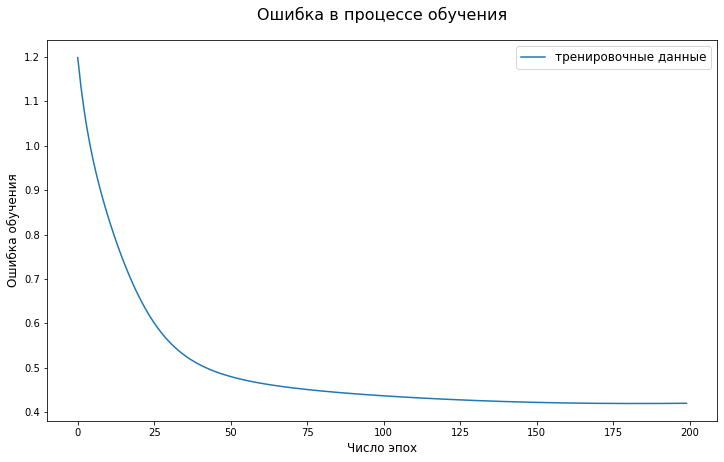

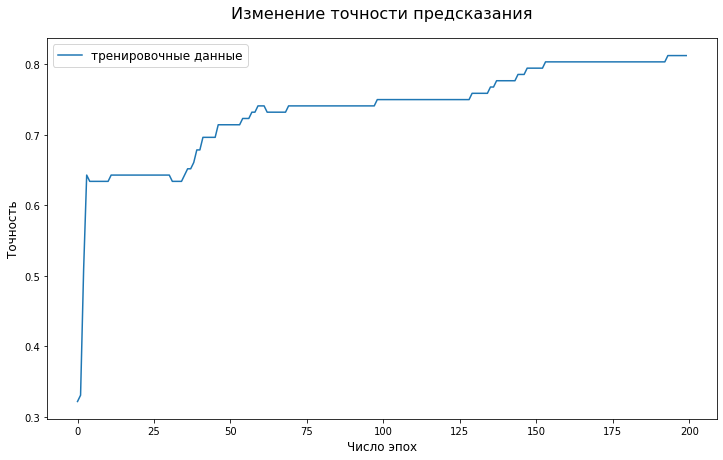

In [ ]:
model_training(dense_model, x_train, y_train, epochs, batch_size, optimizer_params, path_data, num_layers)

### **Проверка работы алгоритма на тестовой выборке (без использования оптимизатора Adam)**

In [ ]:
test_recognition(dense_model, x_test, y_test)

Точность работы алгоритма на тестовой выборке - 76.32 %


### **Процесс обучения нейронной сети (с использованием оптимизатора Adam)**

In [ ]:
dense_model = DenseModel(layers_data, drop_rate, initializer)

In [ ]:
epochs = int(input("Число эпох обучения - "))
batch_size = int(input("Размер батча - "))

Число эпох обучения - 200
Размер батча - 4


In [ ]:
# Параметры оптимизатора
optimizer_params = {}
optimizer_params["learning_rate"] = float(input("Шаг обучения - "))
optimizer_params["use_Adam"] = input("Использование оптимизатора Adam (yes/no) - ")
if (optimizer_params["use_Adam"] == "yes"):
  optimizer_params["beta1"] = float(input("Параметр beta1 - ")) # beta1 = 0.9
  optimizer_params["beta2"] = float(input("Параметр beta2 - ")) # beta1 = 0.999

Шаг обучения - 1e-5
Использование оптимизатора Adam (yes/no) - yes
Параметр beta1 - 0.9
Параметр beta2 - 0.999


Эпоха №1/200


  0%|          ? c 

train_loss = 1.0602, train_acc = 0.5536
Эпоха №2/200


  0%|          ? c 

train_loss = 0.9176, train_acc = 0.5982
Эпоха №3/200


  0%|          ? c 

train_loss = 0.8412, train_acc = 0.6339
Эпоха №4/200


  0%|          ? c 

train_loss = 0.7838, train_acc = 0.6339
Эпоха №5/200


  0%|          ? c 

train_loss = 0.7378, train_acc = 0.6339
Эпоха №6/200


  0%|          ? c 

train_loss = 0.7001, train_acc = 0.6429
Эпоха №7/200


  0%|          ? c 

train_loss = 0.6690, train_acc = 0.6429
Эпоха №8/200


  0%|          ? c 

train_loss = 0.6432, train_acc = 0.6429
Эпоха №9/200


  0%|          ? c 

train_loss = 0.6214, train_acc = 0.6429
Эпоха №10/200


  0%|          ? c 

train_loss = 0.6031, train_acc = 0.6429
Эпоха №11/200


  0%|          ? c 

train_loss = 0.5875, train_acc = 0.6429
Эпоха №12/200


  0%|          ? c 

train_loss = 0.5741, train_acc = 0.6429
Эпоха №13/200


  0%|          ? c 

train_loss = 0.5625, train_acc = 0.6429
Эпоха №14/200


  0%|          ? c 

train_loss = 0.5524, train_acc = 0.6429
Эпоха №15/200


  0%|          ? c 

train_loss = 0.5435, train_acc = 0.6429
Эпоха №16/200


  0%|          ? c 

train_loss = 0.5357, train_acc = 0.6339
Эпоха №17/200


  0%|          ? c 

train_loss = 0.5288, train_acc = 0.6339
Эпоха №18/200


  0%|          ? c 

train_loss = 0.5226, train_acc = 0.6339
Эпоха №19/200


  0%|          ? c 

train_loss = 0.5170, train_acc = 0.6339
Эпоха №20/200


  0%|          ? c 

train_loss = 0.5120, train_acc = 0.6339
Эпоха №21/200


  0%|          ? c 

train_loss = 0.5074, train_acc = 0.6518
Эпоха №22/200


  0%|          ? c 

train_loss = 0.5032, train_acc = 0.6518
Эпоха №23/200


  0%|          ? c 

train_loss = 0.4994, train_acc = 0.6518
Эпоха №24/200


  0%|          ? c 

train_loss = 0.4959, train_acc = 0.6518
Эпоха №25/200


  0%|          ? c 

train_loss = 0.4926, train_acc = 0.6696
Эпоха №26/200


  0%|          ? c 

train_loss = 0.4896, train_acc = 0.6875
Эпоха №27/200


  0%|          ? c 

train_loss = 0.4868, train_acc = 0.6964
Эпоха №28/200


  0%|          ? c 

train_loss = 0.4842, train_acc = 0.7054
Эпоха №29/200


  0%|          ? c 

train_loss = 0.4817, train_acc = 0.7054
Эпоха №30/200


  0%|          ? c 

train_loss = 0.4794, train_acc = 0.7143
Эпоха №31/200


  0%|          ? c 

train_loss = 0.4773, train_acc = 0.7143
Эпоха №32/200


  0%|          ? c 

train_loss = 0.4752, train_acc = 0.7232
Эпоха №33/200


  0%|          ? c 

train_loss = 0.4733, train_acc = 0.7321
Эпоха №34/200


  0%|          ? c 

train_loss = 0.4714, train_acc = 0.7321
Эпоха №35/200


  0%|          ? c 

train_loss = 0.4697, train_acc = 0.7232
Эпоха №36/200


  0%|          ? c 

train_loss = 0.4680, train_acc = 0.7232
Эпоха №37/200


  0%|          ? c 

train_loss = 0.4665, train_acc = 0.7232
Эпоха №38/200


  0%|          ? c 

train_loss = 0.4650, train_acc = 0.7321
Эпоха №39/200


  0%|          ? c 

train_loss = 0.4635, train_acc = 0.7411
Эпоха №40/200


  0%|          ? c 

train_loss = 0.4621, train_acc = 0.7411
Эпоха №41/200


  0%|          ? c 

train_loss = 0.4608, train_acc = 0.7411
Эпоха №42/200


  0%|          ? c 

train_loss = 0.4595, train_acc = 0.7411
Эпоха №43/200


  0%|          ? c 

train_loss = 0.4583, train_acc = 0.7411
Эпоха №44/200


  0%|          ? c 

train_loss = 0.4571, train_acc = 0.7411
Эпоха №45/200


  0%|          ? c 

train_loss = 0.4560, train_acc = 0.7411
Эпоха №46/200


  0%|          ? c 

train_loss = 0.4549, train_acc = 0.7411
Эпоха №47/200


  0%|          ? c 

train_loss = 0.4539, train_acc = 0.7500
Эпоха №48/200


  0%|          ? c 

train_loss = 0.4529, train_acc = 0.7500
Эпоха №49/200


  0%|          ? c 

train_loss = 0.4519, train_acc = 0.7500
Эпоха №50/200


  0%|          ? c 

train_loss = 0.4509, train_acc = 0.7500
Эпоха №51/200


  0%|          ? c 

train_loss = 0.4500, train_acc = 0.7500
Эпоха №52/200


  0%|          ? c 

train_loss = 0.4491, train_acc = 0.7500
Эпоха №53/200


  0%|          ? c 

train_loss = 0.4482, train_acc = 0.7500
Эпоха №54/200


  0%|          ? c 

train_loss = 0.4474, train_acc = 0.7500
Эпоха №55/200


  0%|          ? c 

train_loss = 0.4466, train_acc = 0.7589
Эпоха №56/200


  0%|          ? c 

train_loss = 0.4458, train_acc = 0.7679
Эпоха №57/200


  0%|          ? c 

train_loss = 0.4450, train_acc = 0.7679
Эпоха №58/200


  0%|          ? c 

train_loss = 0.4443, train_acc = 0.7679
Эпоха №59/200


  0%|          ? c 

train_loss = 0.4435, train_acc = 0.7679
Эпоха №60/200


  0%|          ? c 

train_loss = 0.4428, train_acc = 0.7768
Эпоха №61/200


  0%|          ? c 

train_loss = 0.4421, train_acc = 0.7768
Эпоха №62/200


  0%|          ? c 

train_loss = 0.4414, train_acc = 0.7768
Эпоха №63/200


  0%|          ? c 

train_loss = 0.4408, train_acc = 0.7768
Эпоха №64/200


  0%|          ? c 

train_loss = 0.4401, train_acc = 0.7768
Эпоха №65/200


  0%|          ? c 

train_loss = 0.4395, train_acc = 0.7768
Эпоха №66/200


  0%|          ? c 

train_loss = 0.4389, train_acc = 0.7768
Эпоха №67/200


  0%|          ? c 

train_loss = 0.4383, train_acc = 0.7768
Эпоха №68/200


  0%|          ? c 

train_loss = 0.4377, train_acc = 0.7768
Эпоха №69/200


  0%|          ? c 

train_loss = 0.4371, train_acc = 0.7768
Эпоха №70/200


  0%|          ? c 

train_loss = 0.4366, train_acc = 0.7768
Эпоха №71/200


  0%|          ? c 

train_loss = 0.4360, train_acc = 0.7768
Эпоха №72/200


  0%|          ? c 

train_loss = 0.4355, train_acc = 0.7768
Эпоха №73/200


  0%|          ? c 

train_loss = 0.4349, train_acc = 0.7768
Эпоха №74/200


  0%|          ? c 

train_loss = 0.4344, train_acc = 0.7768
Эпоха №75/200


  0%|          ? c 

train_loss = 0.4339, train_acc = 0.7768
Эпоха №76/200


  0%|          ? c 

train_loss = 0.4334, train_acc = 0.7857
Эпоха №77/200


  0%|          ? c 

train_loss = 0.4329, train_acc = 0.7857
Эпоха №78/200


  0%|          ? c 

train_loss = 0.4325, train_acc = 0.7857
Эпоха №79/200


  0%|          ? c 

train_loss = 0.4320, train_acc = 0.7857
Эпоха №80/200


  0%|          ? c 

train_loss = 0.4315, train_acc = 0.7946
Эпоха №81/200


  0%|          ? c 

train_loss = 0.4311, train_acc = 0.7946
Эпоха №82/200


  0%|          ? c 

train_loss = 0.4306, train_acc = 0.7946
Эпоха №83/200


  0%|          ? c 

train_loss = 0.4302, train_acc = 0.7946
Эпоха №84/200


  0%|          ? c 

train_loss = 0.4298, train_acc = 0.7946
Эпоха №85/200


  0%|          ? c 

train_loss = 0.4294, train_acc = 0.7946
Эпоха №86/200


  0%|          ? c 

train_loss = 0.4290, train_acc = 0.7946
Эпоха №87/200


  0%|          ? c 

train_loss = 0.4286, train_acc = 0.7946
Эпоха №88/200


  0%|          ? c 

train_loss = 0.4282, train_acc = 0.7946
Эпоха №89/200


  0%|          ? c 

train_loss = 0.4278, train_acc = 0.7946
Эпоха №90/200


  0%|          ? c 

train_loss = 0.4274, train_acc = 0.8036
Эпоха №91/200


  0%|          ? c 

train_loss = 0.4270, train_acc = 0.8036
Эпоха №92/200


  0%|          ? c 

train_loss = 0.4267, train_acc = 0.8036
Эпоха №93/200


  0%|          ? c 

train_loss = 0.4263, train_acc = 0.8036
Эпоха №94/200


  0%|          ? c 

train_loss = 0.4259, train_acc = 0.8036
Эпоха №95/200


  0%|          ? c 

train_loss = 0.4256, train_acc = 0.8036
Эпоха №96/200


  0%|          ? c 

train_loss = 0.4252, train_acc = 0.8125
Эпоха №97/200


  0%|          ? c 

train_loss = 0.4249, train_acc = 0.8125
Эпоха №98/200


  0%|          ? c 

train_loss = 0.4246, train_acc = 0.8125
Эпоха №99/200


  0%|          ? c 

train_loss = 0.4242, train_acc = 0.8125
Эпоха №100/200


  0%|          ? c 

train_loss = 0.4239, train_acc = 0.8125
Эпоха №101/200


  0%|          ? c 

train_loss = 0.4236, train_acc = 0.8125
Эпоха №102/200


  0%|          ? c 

train_loss = 0.4233, train_acc = 0.8125
Эпоха №103/200


  0%|          ? c 

train_loss = 0.4230, train_acc = 0.8125
Эпоха №104/200


  0%|          ? c 

train_loss = 0.4227, train_acc = 0.8125
Эпоха №105/200


  0%|          ? c 

train_loss = 0.4224, train_acc = 0.8036
Эпоха №106/200


  0%|          ? c 

train_loss = 0.4221, train_acc = 0.8036
Эпоха №107/200


  0%|          ? c 

train_loss = 0.4218, train_acc = 0.8036
Эпоха №108/200


  0%|          ? c 

train_loss = 0.4215, train_acc = 0.8036
Эпоха №109/200


  0%|          ? c 

train_loss = 0.4212, train_acc = 0.8036
Эпоха №110/200


  0%|          ? c 

train_loss = 0.4209, train_acc = 0.8036
Эпоха №111/200


  0%|          ? c 

train_loss = 0.4206, train_acc = 0.8036
Эпоха №112/200


  0%|          ? c 

train_loss = 0.4204, train_acc = 0.8036
Эпоха №113/200


  0%|          ? c 

train_loss = 0.4201, train_acc = 0.8036
Эпоха №114/200


  0%|          ? c 

train_loss = 0.4198, train_acc = 0.8036
Эпоха №115/200


  0%|          ? c 

train_loss = 0.4196, train_acc = 0.8036
Эпоха №116/200


  0%|          ? c 

train_loss = 0.4193, train_acc = 0.8036
Эпоха №117/200


  0%|          ? c 

train_loss = 0.4191, train_acc = 0.8036
Эпоха №118/200


  0%|          ? c 

train_loss = 0.4188, train_acc = 0.8036
Эпоха №119/200


  0%|          ? c 

train_loss = 0.4186, train_acc = 0.8036
Эпоха №120/200


  0%|          ? c 

train_loss = 0.4183, train_acc = 0.8036
Эпоха №121/200


  0%|          ? c 

train_loss = 0.4181, train_acc = 0.8036
Эпоха №122/200


  0%|          ? c 

train_loss = 0.4178, train_acc = 0.8036
Эпоха №123/200


  0%|          ? c 

train_loss = 0.4176, train_acc = 0.8036
Эпоха №124/200


  0%|          ? c 

train_loss = 0.4174, train_acc = 0.8036
Эпоха №125/200


  0%|          ? c 

train_loss = 0.4171, train_acc = 0.8036
Эпоха №126/200


  0%|          ? c 

train_loss = 0.4169, train_acc = 0.8036
Эпоха №127/200


  0%|          ? c 

train_loss = 0.4167, train_acc = 0.8036
Эпоха №128/200


  0%|          ? c 

train_loss = 0.4165, train_acc = 0.8036
Эпоха №129/200


  0%|          ? c 

train_loss = 0.4162, train_acc = 0.8036
Эпоха №130/200


  0%|          ? c 

train_loss = 0.4160, train_acc = 0.8036
Эпоха №131/200


  0%|          ? c 

train_loss = 0.4158, train_acc = 0.8125
Эпоха №132/200


  0%|          ? c 

train_loss = 0.4156, train_acc = 0.8125
Эпоха №133/200


  0%|          ? c 

train_loss = 0.4154, train_acc = 0.8125
Эпоха №134/200


  0%|          ? c 

train_loss = 0.4152, train_acc = 0.8125
Эпоха №135/200


  0%|          ? c 

train_loss = 0.4150, train_acc = 0.8125
Эпоха №136/200


  0%|          ? c 

train_loss = 0.4148, train_acc = 0.8125
Эпоха №137/200


  0%|          ? c 

train_loss = 0.4146, train_acc = 0.8125
Эпоха №138/200


  0%|          ? c 

train_loss = 0.4144, train_acc = 0.8125
Эпоха №139/200


  0%|          ? c 

train_loss = 0.4142, train_acc = 0.8125
Эпоха №140/200


  0%|          ? c 

train_loss = 0.4140, train_acc = 0.8125
Эпоха №141/200


  0%|          ? c 

train_loss = 0.4138, train_acc = 0.8125
Эпоха №142/200


  0%|          ? c 

train_loss = 0.4136, train_acc = 0.8125
Эпоха №143/200


  0%|          ? c 

train_loss = 0.4134, train_acc = 0.8125
Эпоха №144/200


  0%|          ? c 

train_loss = 0.4132, train_acc = 0.8125
Эпоха №145/200


  0%|          ? c 

train_loss = 0.4130, train_acc = 0.8125
Эпоха №146/200


  0%|          ? c 

train_loss = 0.4128, train_acc = 0.8125
Эпоха №147/200


  0%|          ? c 

train_loss = 0.4127, train_acc = 0.8125
Эпоха №148/200


  0%|          ? c 

train_loss = 0.4125, train_acc = 0.8214
Эпоха №149/200


  0%|          ? c 

train_loss = 0.4123, train_acc = 0.8214
Эпоха №150/200


  0%|          ? c 

train_loss = 0.4121, train_acc = 0.8214
Эпоха №151/200


  0%|          ? c 

train_loss = 0.4119, train_acc = 0.8214
Эпоха №152/200


  0%|          ? c 

train_loss = 0.4118, train_acc = 0.8214
Эпоха №153/200


  0%|          ? c 

train_loss = 0.4116, train_acc = 0.8304
Эпоха №154/200


  0%|          ? c 

train_loss = 0.4114, train_acc = 0.8304
Эпоха №155/200


  0%|          ? c 

train_loss = 0.4113, train_acc = 0.8304
Эпоха №156/200


  0%|          ? c 

train_loss = 0.4111, train_acc = 0.8304
Эпоха №157/200


  0%|          ? c 

train_loss = 0.4109, train_acc = 0.8304
Эпоха №158/200


  0%|          ? c 

train_loss = 0.4108, train_acc = 0.8304
Эпоха №159/200


  0%|          ? c 

train_loss = 0.4106, train_acc = 0.8304
Эпоха №160/200


  0%|          ? c 

train_loss = 0.4104, train_acc = 0.8304
Эпоха №161/200


  0%|          ? c 

train_loss = 0.4103, train_acc = 0.8304
Эпоха №162/200


  0%|          ? c 

train_loss = 0.4101, train_acc = 0.8304
Эпоха №163/200


  0%|          ? c 

train_loss = 0.4099, train_acc = 0.8304
Эпоха №164/200


  0%|          ? c 

train_loss = 0.4098, train_acc = 0.8304
Эпоха №165/200


  0%|          ? c 

train_loss = 0.4096, train_acc = 0.8304
Эпоха №166/200


  0%|          ? c 

train_loss = 0.4095, train_acc = 0.8304
Эпоха №167/200


  0%|          ? c 

train_loss = 0.4093, train_acc = 0.8304
Эпоха №168/200


  0%|          ? c 

train_loss = 0.4092, train_acc = 0.8304
Эпоха №169/200


  0%|          ? c 

train_loss = 0.4090, train_acc = 0.8304
Эпоха №170/200


  0%|          ? c 

train_loss = 0.4089, train_acc = 0.8304
Эпоха №171/200


  0%|          ? c 

train_loss = 0.4087, train_acc = 0.8304
Эпоха №172/200


  0%|          ? c 

train_loss = 0.4086, train_acc = 0.8304
Эпоха №173/200


  0%|          ? c 

train_loss = 0.4084, train_acc = 0.8304
Эпоха №174/200


  0%|          ? c 

train_loss = 0.4083, train_acc = 0.8304
Эпоха №175/200


  0%|          ? c 

train_loss = 0.4081, train_acc = 0.8304
Эпоха №176/200


  0%|          ? c 

train_loss = 0.4080, train_acc = 0.8304
Эпоха №177/200


  0%|          ? c 

train_loss = 0.4079, train_acc = 0.8304
Эпоха №178/200


  0%|          ? c 

train_loss = 0.4077, train_acc = 0.8304
Эпоха №179/200


  0%|          ? c 

train_loss = 0.4076, train_acc = 0.8304
Эпоха №180/200


  0%|          ? c 

train_loss = 0.4074, train_acc = 0.8304
Эпоха №181/200


  0%|          ? c 

train_loss = 0.4073, train_acc = 0.8304
Эпоха №182/200


  0%|          ? c 

train_loss = 0.4072, train_acc = 0.8304
Эпоха №183/200


  0%|          ? c 

train_loss = 0.4070, train_acc = 0.8304
Эпоха №184/200


  0%|          ? c 

train_loss = 0.4069, train_acc = 0.8304
Эпоха №185/200


  0%|          ? c 

train_loss = 0.4068, train_acc = 0.8304
Эпоха №186/200


  0%|          ? c 

train_loss = 0.4066, train_acc = 0.8304
Эпоха №187/200


  0%|          ? c 

train_loss = 0.4065, train_acc = 0.8304
Эпоха №188/200


  0%|          ? c 

train_loss = 0.4064, train_acc = 0.8304
Эпоха №189/200


  0%|          ? c 

train_loss = 0.4062, train_acc = 0.8304
Эпоха №190/200


  0%|          ? c 

train_loss = 0.4061, train_acc = 0.8304
Эпоха №191/200


  0%|          ? c 

train_loss = 0.4060, train_acc = 0.8304
Эпоха №192/200


  0%|          ? c 

train_loss = 0.4058, train_acc = 0.8304
Эпоха №193/200


  0%|          ? c 

train_loss = 0.4057, train_acc = 0.8304
Эпоха №194/200


  0%|          ? c 

train_loss = 0.4056, train_acc = 0.8304
Эпоха №195/200


  0%|          ? c 

train_loss = 0.4054, train_acc = 0.8393
Эпоха №196/200


  0%|          ? c 

train_loss = 0.4053, train_acc = 0.8393
Эпоха №197/200


  0%|          ? c 

train_loss = 0.4052, train_acc = 0.8393
Эпоха №198/200


  0%|          ? c 

train_loss = 0.4051, train_acc = 0.8214
Эпоха №199/200


  0%|          ? c 

train_loss = 0.4050, train_acc = 0.8214
Эпоха №200/200


  0%|          ? c 

train_loss = 0.4048, train_acc = 0.8214


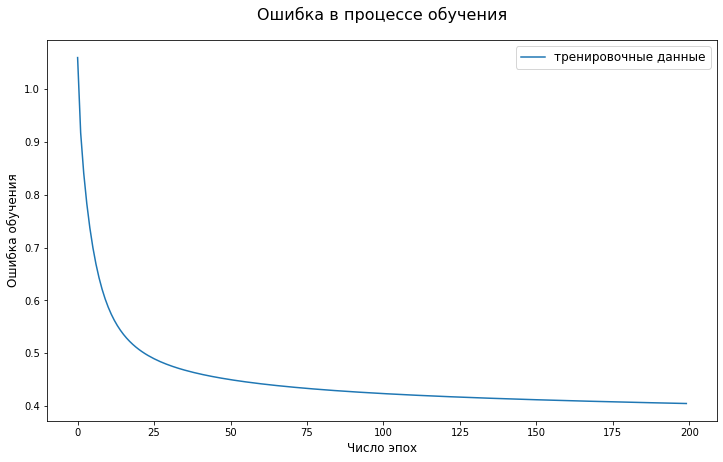

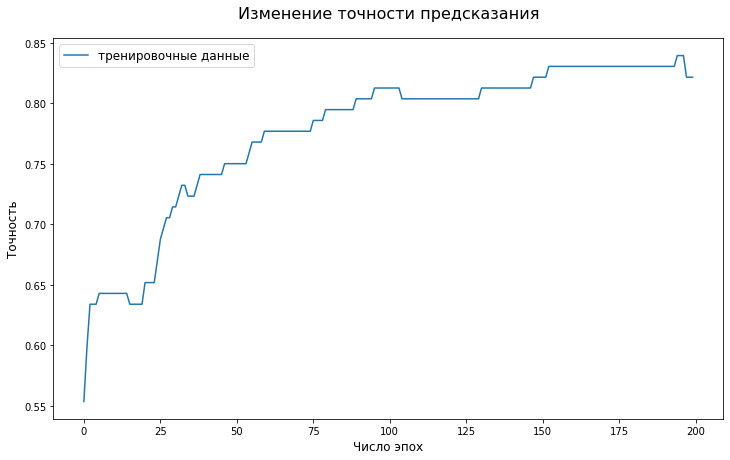

In [ ]:
model_training(dense_model, x_train, y_train, epochs, batch_size, optimizer_params, path_data, num_layers)

### **Проверка работы алгоритма на тестовой выборке (с использованием оптимизатора Adam)**

In [ ]:
test_recognition(dense_model, x_test, y_test)

Точность работы алгоритма на тестовой выборке - 84.21 %


## **5.) Выводы по работе**



> #### 1.   Использование структуры *zip* не позволяет редактировать содержимое, так как оно представляет собой *tuple*.   
> #### 2.   Для отслеживания изменения весов модели необходимо использовать метод *g.watch()* в блоке *with tf.GradientTape()* 
> #### 3.   Использование проверочной выборки в процессе обучения не несёт в себе информативности, так как размеры выборки очень малы.
> #### 4.   Усложение архитектуры нейронной сети снижает ошибку обучения и увеличивает точность. 
> #### 5.   Использование оптимизатора Adam увеличивает скорость сходимость процесса обучения.
> #### 6.   При реализации оптимизатора параметры *m* и *v* нельзя определить в качестве *np.array*, так как в них необходимо сохранять массивы различной формы.

